In [27]:
pip install lifetimes

In [28]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [29]:
df = pd.read_csv('Online_Retail.csv')

In [30]:
print('\n Top 10 Rows \n',df.head())
print('\n Information on dataset \n',df.info())
print('\n Decription of dataset \n',df.describe())


 Top 10 Rows 
   InvoiceNo StockCode                          Description  Quantity          InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  2010-12-01 08:26:00       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  2010-12-01 08:26:00       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  2010-12-01 08:26:00       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  2010-12-01 08:26:00       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  2010-12-01 08:26:00       3.39     17850.0  United Kingdom
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo

### Data Preprocessing 

In [31]:
df = df[df['Quantity'] > 0 ]
df = df[df['UnitPrice'] > 0]
df = df[~df['InvoiceNo'].str.contains("C",na=False)] # drop returned items

#### Missing Values 

In [32]:
df.dropna(inplace=True)

#### Handling Outliers 

In [33]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [34]:
capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')
df.describe()

,Quantity,UnitPrice,CustomerID
count,354321.000000,354321.000000,354321.000000
mean,8.348212,2.651029,15552.486392
std,9.245021,2.248187,1594.527150
min,1.000000,0.420000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,36.000000,8.500000,18287.000000


#### Creating Column 'Total Price' 

In [35]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Creating Summary Dataset
By using lifetimes we can also create our RFM data from the original dataset.

- Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

- Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

- T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

- Monetary_Value represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [36]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price',observation_period_end='2011-12-09')

In [37]:
clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,257.314911
12749.0,3.0,210.0,213.0,999.106667
12820.0,3.0,323.0,326.0,256.573333
12823.0,4.0,222.0,296.0,252.450000


### BG/NBD Model for Predicting Number of Purchase 

In [38]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1738 subjects, a: 0.00, alpha: 112.07, b: 0.00, r: 2.38>

#### Summary of BG/NBD Model 

In [39]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.381731e+00,1.013873e-01,2.183012e+00,2.580451e+00
alpha,1.120749e+02,5.267568e+00,1.017504e+02,1.223993e+02
a,2.301100e-14,3.668821e-10,-7.190659e-10,7.191119e-10
b,2.398753e-05,3.819872e-01,-7.486709e-01,7.487189e-01


### Visualizing our Frequency/Recency Matrix 

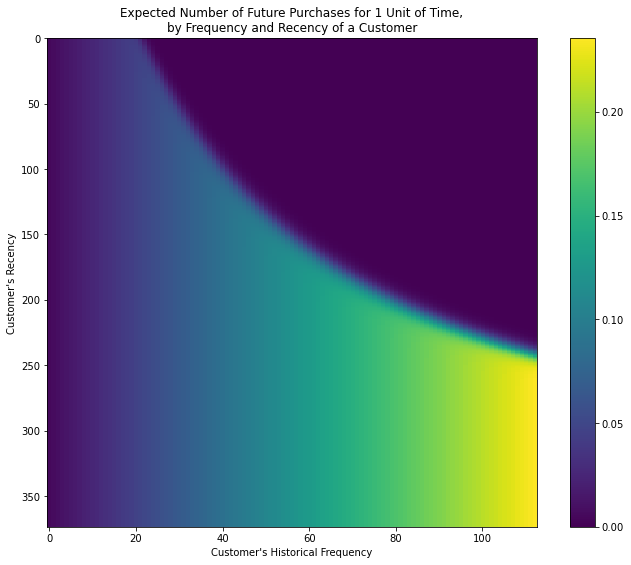

In [40]:
plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()

#### Expected Number of Purchases in 6 Months

In [41]:
t = 180 # 30 day period
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months
CustomerID,,,,,
12748.0,112.0,373.0,373.0,257.314911,42.444401
17841.0,111.0,372.0,373.0,349.079640,42.073324
15311.0,89.0,373.0,373.0,421.881573,33.909635
14606.0,88.0,372.0,373.0,125.302955,33.538559
12971.0,70.0,369.0,372.0,132.197571,26.914663


### Gamma - Gamma Model
The Gamma-Gamma Model can predict the most likely value per transaction in the future

#### Assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [42]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.082631
monetary_value,0.082631,1.000000


In [43]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1738 subjects, p: 3.80, q: 0.35, v: 3.73>

### 6 months Customer Lifetime Value 

In [44]:
clv['6_Months_CLV']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)

In [45]:
clv.sort_values('6_Months_CLV',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
CustomerID,,,,,,
14096.0,16.0,97.0,101.0,3012.454375,15.528400,45677.610915
18102.0,25.0,367.0,367.0,2112.843200,10.287978,21142.592872
13089.0,65.0,367.0,369.0,784.818308,25.211693,19164.137958
17511.0,27.0,371.0,373.0,1798.113704,10.902877,19058.975876
14088.0,11.0,312.0,322.0,3352.988182,5.549070,18258.492844


### Segmentation Customers by 6 Months CLV 

In [46]:
clv['Segment'] =  pd.qcut(clv['6_Months_CLV'],4,labels = ['Hibernating','Need Attention',
                                                          'Loyal Customers','Champions'])

In [47]:
clv.head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV,Segment
CustomerID,,,,,,,
12747.0,10.0,367.0,369.0,375.725000,4.632775,1712.381633,Champions
12748.0,112.0,373.0,373.0,257.314911,42.444401,10566.853327,Champions
12749.0,3.0,210.0,213.0,999.106667,2.979965,3054.158128,Champions
12820.0,3.0,323.0,326.0,256.573333,2.211293,584.100407,Need Attention
12823.0,4.0,222.0,296.0,252.450000,2.814953,719.842220,Need Attention


### Final Dataframe

In [48]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
Segment,,,,,,
Hibernating,3.174713,221.337931,292.245977,147.152900,2.553847,364.667903
Need Attention,4.027650,240.140553,284.440092,265.378345,2.989161,745.573232
Loyal Customers,5.592166,242.944700,276.027650,365.362234,3.759721,1234.753807
Champions,11.108046,261.354023,280.475862,584.771128,5.994943,3095.935737


### Group by Segment 

In [49]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
Segment,,,,,,
Hibernating,3.174713,221.337931,292.245977,147.152900,2.553847,364.667903
Need Attention,4.027650,240.140553,284.440092,265.378345,2.989161,745.573232
Loyal Customers,5.592166,242.944700,276.027650,365.362234,3.759721,1234.753807
Champions,11.108046,261.354023,280.475862,584.771128,5.994943,3095.935737
